# Topic Modeling

Game reviews are a great source of information for players. From the company's point of view, online reviews can be used to gauge feedback on the game. However, since these reviews can be overwhelming in terms of numbers and information, we can use topic modeling to find key insights. This enables people wanting to play the game to quickly extract key information without having the tedious task of going through every review. As well, this serves as another avenue of information that the company can use to inform product decisions.

### Import Libraries

In [162]:
import pandas as pd
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 500)
import numpy as np
import re
import pprint as pp
from datetime import datetime
import pickle
from pprint import pprint
import warnings
warnings.simplefilter("ignore")

# Natural language processing libraries
import nltk
from nltk import FreqDist
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy

# Library for unsupervised topic modeling
import gensim
from gensim import corpora
from gensim.models import CoherenceModel

# Libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gthorani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [144]:
df = pd.read_csv('game_reviews.csv')

In [131]:
df.head(1)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOEG_RTpX1xcPi63E1XUWl_oInN9kAGs79n7WFowsa5at9eD8FCoNyHwF5MZGmjI-ejwkD338fCW65ixrg,ahmed gamal,https://lh3.googleusercontent.com/-_pEzLxFt3No/AAAAAAAAAAI/AAAAAAAAAAA/AMZuucm54H8j-gkfIXvvHKTqUrixcUpAZQ/photo.jpg,They have the antention to make you loose in order to buy very very bad ecperince not recommend at all,1,0,NaN,2020-06-22 00:40:06,NaN,NaN


## Data Preprocessing

In [5]:
clean_df = df[['at','content','score','thumbsUpCount','reviewCreatedVersion']]

In [6]:
clean_df.columns = ['date','review','rating','thumbs_up','version']

In [7]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197096 entries, 0 to 197095
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   date       197096 non-null  object
 1   review     196843 non-null  object
 2   rating     197096 non-null  int64 
 3   thumbs_up  197096 non-null  int64 
 4   version    168724 non-null  object
dtypes: int64(2), object(3)
memory usage: 7.5+ MB


There are 253(.001%) reviews with no text and 28372(14%) of the reviews do not have an associated version number.

In [8]:
# Drop the null reviews
clean_df = clean_df[~clean_df['review'].isna()]

In [9]:
clean_df.shape

(196843, 5)

In [10]:
# Function to plot the most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([str(text) for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns = 'count', n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x = 'word', y = 'count', palette = 'Blues_r')
    ax.set(ylabel = 'Count')
    plt.show()

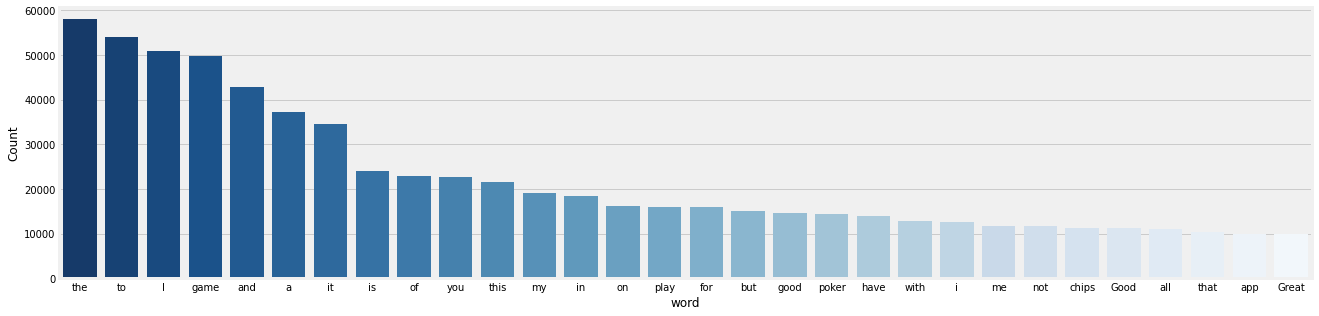

In [11]:
freq_words(clean_df['review'])

Common words such as: to, I, the, it are not important for our task. Thus, we will get rid of any unnecessary words.

In [12]:
# remove unwanted characters, numbers and symbols
clean_df['review'] = clean_df['review'].str.replace('[^a-zA-Z#]', ' ')

In [13]:
#emoji removal
clean_df['review'] = clean_df['review'].str.replace(r'[^\x00-\x7F]+', '')

In [14]:
stop_words = stopwords.words('english')

In [15]:
# Function to remove stopwords
def remove_stopwords(review):
    clean_review = ' '.join([i for i in review if i not in stop_words])
    return clean_review

In [16]:
# Remove short words (length < 3)
clean_df['review'] = clean_df['review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [17]:
# Remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in clean_df['review']]

In [18]:
# Makes entire text lowercase
reviews = [r.lower() for r in reviews]

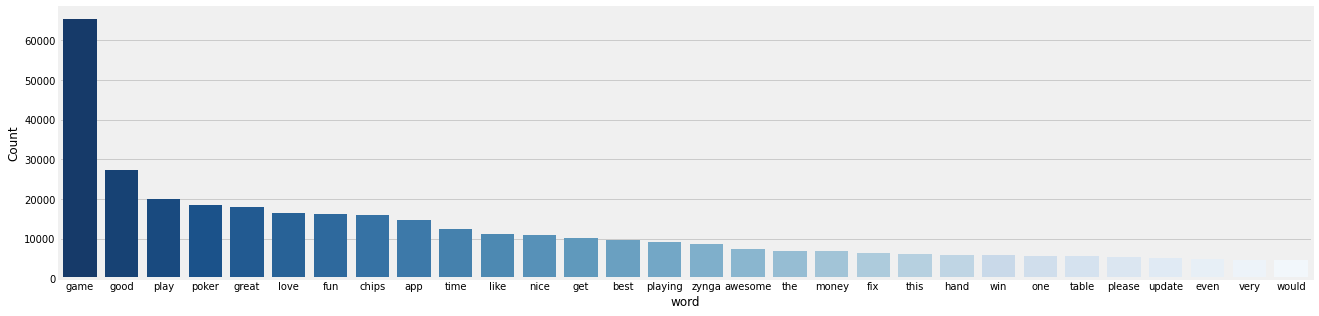

In [19]:
freq_words(reviews)

We can see some improvement as the most frequent words are **game, play, poker, chips, table** which are all relevant with Zynga Poker. There are still redundant words such as, **this, get** and **the**. 

In [ ]:
!python -m spacy download en

### Tokenization & Lemmatization

In [21]:
token_reviews = pd.Series(reviews).apply(lambda x: x.split())
pp.pprint(token_reviews[12])

['daily',
 'friend',
 'bonus',
 'work',
 'first',
 'month',
 'seport',
 'see',
 'problem',
 'numerous',
 'screenshots',
 'proof',
 'very',
 'bad']


In [22]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatize(texts, tags=['NOUN', 'ADJ']): # Filters nouns and adjectives
    output = []
    for sent in texts:
        doc = nlp(' '.join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [27]:
lem_reviews = lemmatize(token_reviews)
print(lem_reviews[0]) # print lemmatized review

['antention', 'loose', 'order', 'bad', 'ecperince', 'recommend']


In [28]:
len(lem_reviews)

196843

In [29]:
# Save the lemmatized reviews because it takes so long!
with open('lem_reviews.txt', 'wb') as fp:   #Pickling
    pickle.dump(lem_reviews, fp)

In [30]:
with open('lem_reviews.txt', 'rb') as fp:   # Unpickling
    texts = pickle.load(fp)                 # This will be used to create our corpus

Removed further noise from the text (i.e., **this** is removed).

In [32]:
reviews_clean = []
for i in range(len(texts)):
    reviews_clean.append(' '.join(texts[i]))

clean_df['clean_review'] = reviews_clean

In [33]:
32013/196843

0.1626321484634963

In [34]:
clean_df[clean_df['clean_review']==''].shape

(32013, 6)

32013 (16%) reviews were removed from the original data set as these reviews did not give helpful information and are now empty after pre-processing.

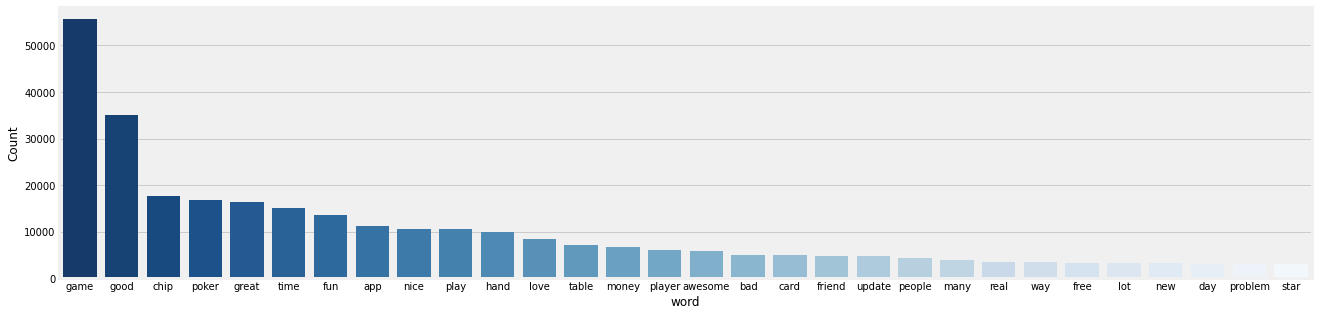

In [35]:
freq_words(clean_df['clean_review'])

We now have more relevant terms we can use to build our topic model.

## LDA Model

In [36]:
# Creates a dictionary to hold all unique terms and assigns an index
id2word = corpora.Dictionary(texts)

In [37]:
# Converts the list of review into a Document Term Matrix
corpus = [id2word.doc2bow(review) for review in texts]

In [38]:
corpus[0]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]

Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

In [72]:
# Creates object for LDA model using the gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model =LDA(corpus=corpus,
               id2word=id2word,
               num_topics=5, 
               random_state=100,
               update_every=1,
               chunksize=100,
               passes=10,
               alpha='auto',
               per_word_topics=True)

The model is built with 5 different topics where each topic is a combination of keywords and each keyword has a certain weight associated to the topic.

In [ ]:
# Save the LDA model!
with open('lda_model.pkl', 'wb') as fp:   #Pickling
    pickle.dump(lda_model, fp)

In [39]:
with open('lda_model.pkl', 'rb') as fp:   # Unpickling
    lda_model = pickle.load(fp)                 # This will be used to create our corpus

In [40]:
lda_model.print_topics()

[(0,
  '0.119*"amazing" + 0.052*"hand" + 0.046*"new" + 0.043*"card" + 0.028*"win" + 0.025*"update" + 0.022*"tournament" + 0.020*"different" + 0.019*"site" + 0.019*"version"'),
 (1,
  '0.096*"year" + 0.060*"playing" + 0.044*"fantastic" + 0.033*"hour" + 0.032*"enjoy" + 0.024*"able" + 0.024*"account" + 0.023*"interesting" + 0.022*"use" + 0.019*"long"'),
 (2,
  '0.174*"poker" + 0.130*"fun" + 0.090*"time" + 0.075*"play" + 0.056*"app" + 0.040*"addictive" + 0.025*"real" + 0.024*"player" + 0.023*"way" + 0.021*"lot"'),
 (3,
  '0.368*"great" + 0.194*"awesome" + 0.031*"excellent" + 0.030*"thank" + 0.026*"table" + 0.024*"graphic" + 0.019*"job" + 0.014*"work" + 0.013*"favorite" + 0.011*"phone"'),
 (4,
  '0.310*"game" + 0.238*"good" + 0.084*"love" + 0.074*"nice" + 0.040*"chip" + 0.018*"cool" + 0.014*"money" + 0.012*"free" + 0.011*"well" + 0.010*"people"')]

**Topic 3** seems to be about a positive experience and time consuming because it has terms: **fun, time, addictive**.  

In [77]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. Lower means better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.55033709643975

Coherence Score:  0.3674213932813827


## Visualization

In [79]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.428203  0.049261       1        1  41.156761
2     -0.048574 -0.397857       2        1  27.261797
3     -0.093913  0.191666       3        1  14.693078
0     -0.144776  0.078663       4        1  10.207417
1     -0.140939  0.078266       5        1   6.680947, topic_info=          Term          Freq         Total Category  logprob  loglift
42        game  79035.000000  79035.000000  Default  30.0000  30.0000
181      great  33552.000000  33552.000000  Default  29.0000  29.0000
103       good  60653.000000  60653.000000  Default  28.0000  28.0000
9        poker  29410.000000  29410.000000  Default  27.0000  27.0000
528    awesome  17670.000000  17670.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
518       seat    304.379913    305.906342   Topic5  -4.9139   2.7009
587        buy    285.008453    286.454803   Topic5  -4.9796   2.7008
227      small    271.492920    272.939789   Topic5  -5.0282   2.7006
1995  beginner    257.333923    258.776550   Topic5  -5.0818   2.7003
1836     class    223.038132    224.472687   Topic5  -5.2248   2.6995

[181 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
187       5  0.998792       able
111       5  0.998576    account
365       5  0.997474     action
8435      4  0.997831  addicting
1153      2  0.999856  addictive
...     ...       ...        ...
145       4  0.999072        win
846       4  0.998299  wonderful
63        3  0.999084       work
171       2  0.997794      world
283       5  0.999698       year

[151 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 1, 2])

- Topic 1 is the most prevalent as it has the largest bubble
- This model may not be the best to describe the topics from the reviews as there are overlapping bubbles (Topics 3-5) in top left quadrant
    - This may indicate that there are only 3 definitive topics

## LDA Mallet Model 

Let's see if Mallet's version gives better quality topics.

In [82]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)

In [83]:
ldamallet.show_topics(formatted=False)

[(0,
  [('great', 0.12863114922140317),
   ('fun', 0.12103682179179777),
   ('game', 0.11138346896754583),
   ('nice', 0.09415361577338242),
   ('love', 0.06315235896567399),
   ('awesome', 0.051653905463102445),
   ('update', 0.04298995445186248),
   ('lot', 0.027409104279385678),
   ('cool', 0.020625908065853158),
   ('version', 0.020242626282434107)]),
 (1,
  [('table', 0.061680182528220946),
   ('time', 0.0528272219990942),
   ('app', 0.043760628252565735),
   ('problem', 0.0253625355699307),
   ('star', 0.024132008237696862),
   ('fix', 0.022431487827179273),
   ('connection', 0.021329140425386462),
   ('account', 0.02038915426881895),
   ('tournament', 0.020149885065329037),
   ('thing', 0.016313032480794375)]),
 (2,
  [('chip', 0.14237551238206117),
   ('hand', 0.0796284168910233),
   ('money', 0.05354645193108411),
   ('player', 0.04903506431557075),
   ('card', 0.04099056489364283),
   ('people', 0.03498346633033383),
   ('win', 0.02132802962316169),
   ('bad', 0.0210288874336

In [85]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5235269043821272


By using a different LDA algorithm, the coherence score increased from 0.37 to 0.52.

### Find optimal # of topics

In [86]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [87]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=40, step=6)

In [88]:
# Save the LDA model list!
with open('lda_model_list.pkl', 'wb') as fp:   #Pickling
    pickle.dump(model_list, fp)

In [41]:
with open('lda_model_list.pkl', 'rb') as fp:   # Unpickling
    model_list = pickle.load(fp)                 # This will be used to create our corpus

In [89]:
# Save the coherence values
with open('coherence_values.pkl', 'wb') as fp:   #Pickling
    pickle.dump(coherence_values, fp)

In [42]:
with open('coherence_values.pkl', 'rb') as fp:   # Unpickling
    coherence_values = pickle.load(fp)                 # This will be used to create our corpus

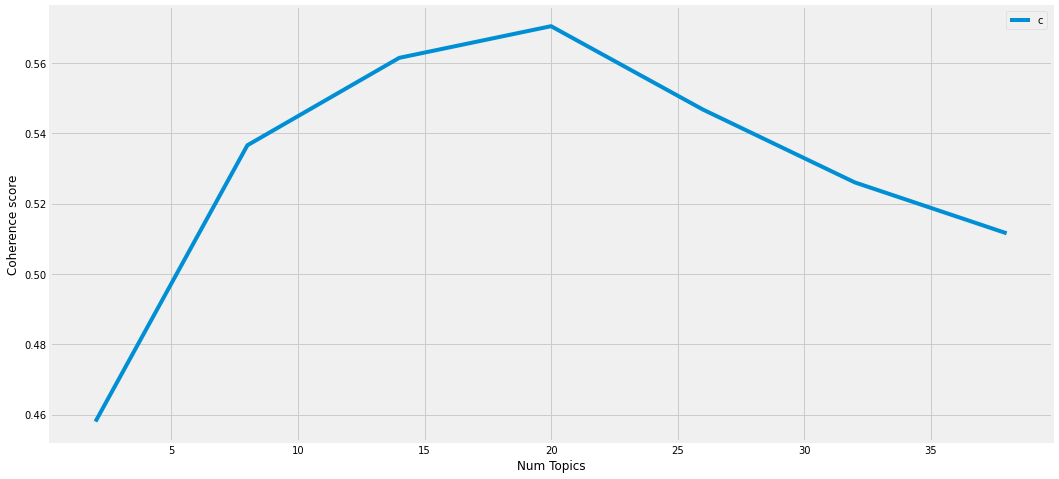

In [43]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [44]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.458
Num Topics = 8  has Coherence Value of 0.5366
Num Topics = 14  has Coherence Value of 0.5615
Num Topics = 20  has Coherence Value of 0.5705
Num Topics = 26  has Coherence Value of 0.5468
Num Topics = 32  has Coherence Value of 0.5261
Num Topics = 38  has Coherence Value of 0.5116


There's a peak at 20 topics. It is also possible to go with 14 topics as the difference in coherence is only 0.85.

In [45]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.197*"game" + 0.105*"day" + 0.101*"play" + 0.067*"gift" + 0.067*"thing" + '
  '0.039*"hour" + 0.036*"ad" + 0.032*"stupid" + 0.032*"happy" + 0.023*"week"'),
 (1,
  '0.285*"game" + 0.123*"love" + 0.120*"nice" + 0.119*"awesome" + 0.086*"cool" '
  '+ 0.054*"good" + 0.035*"excellent" + 0.017*"brilliant" + 0.017*"lol" + '
  '0.016*"interesting"'),
 (2,
  '0.463*"chip" + 0.109*"free" + 0.059*"spin" + 0.037*"bonus" + 0.028*"coin" + '
  '0.021*"gold" + 0.020*"purchase" + 0.019*"lucky" + 0.019*"video" + '
  '0.015*"daily"'),
 (3,
  '0.103*"problem" + 0.092*"fix" + 0.087*"connection" + 0.061*"app" + '
  '0.059*"issue" + 0.054*"error" + 0.043*"bug" + 0.031*"internet" + '
  '0.025*"work" + 0.021*"open"'),
 (4,
  '0.490*"great" + 0.089*"game" + 0.039*"slow" + 0.039*"graphic" + 0.031*"fun" '
  '+ 0.025*"enjoyable" + 0.022*"fast" + 0.022*"job" + 0.020*"fantastic" + '
  '0.019*"bit"'),
 (5,
  '0.529*"time" + 0.033*"long" + 0.032*"alot" + 0.027*"waste" + 0.019*"worth" '
  '+ 0.018*"terrible" + 

In [46]:
final_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

In [100]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(final_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
18     0.148440  0.048748       1        1  5.403781
11     0.150962  0.074872       2        1  5.234112
15     0.156577  0.101562       3        1  5.200749
2      0.167559  0.280173       4        1  5.189631
8      0.171201  0.264381       5        1  5.172176
17     0.143771  0.018180       6        1  5.163582
7      0.166235 -0.120157       7        1  5.073150
5      0.146970  0.026436       8        1  5.059725
13     0.138596 -0.234446       9        1  5.057121
10     0.154270 -0.025106      10        1  5.055672
0     -0.125816 -0.108461      11        1  5.036886
3      0.172469 -0.082743      12        1  5.036018
12     0.005499 -0.077349      13        1  5.031395
19     0.110390 -0.242586      14        1  4.824610
9     -0.332494  0.031361      15        1  4.784833
4     -0.084251 -0.100640      16        1  4.779177
14    -0.328909  0.034094      17        1  4.779144
6     -0.333527  0.048938      18        1  4.750876
16    -0.320897  0.016543      19        1  4.685440
1     -0.307044  0.046200      20        1  4.681924, topic_info=         Term          Freq         Total Category  logprob  loglift
42       game  59309.000000  59309.000000  Default  30.0000  30.0000
103      good  37361.000000  37361.000000  Default  29.0000  29.0000
34       time  16623.000000  16623.000000  Default  28.0000  28.0000
33       chip  18396.000000  18396.000000  Default  27.0000  27.0000
181     great  17410.000000  17410.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
42       game   8276.879122  59309.909445  Topic20  -1.2553   1.0922
103      good   1568.105498  37361.016971  Topic20  -2.9188  -0.1093
550   amazing    208.089829   1844.789458  Topic20  -4.9385   0.8793
4240    sweet     58.392554    179.791557  Topic20  -6.2093   1.9369
181     great    128.463619  17410.884901  Topic20  -5.4208  -1.8477

[1483 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3247     18  0.997927         #
1813      9  0.910083  abrasive
99        2  0.948993  absolute
99       10  0.036267  absolute
99       19  0.012089  absolute
...     ...       ...       ...
4137     19  1.037698      zyng
334       4  0.094997     zynga
334      16  0.895691     zynga
2776      5  0.975880    zyngas
6568     17  0.941597   zzzzzzz

[1896 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 12, 16, 3, 9, 18, 8, 6, 14, 11, 1, 4, 13, 20, 10, 5, 15, 7, 17, 2])

### Find dominant topic in each review

In [52]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['content']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [53]:
# Using the original reviews
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df['content'])

In [54]:
# Save this dataframe
with open('df_topic_sents_keywords.pkl', 'wb') as fp:   #Pickling
    pickle.dump(df_topic_sents_keywords, fp)

In [55]:
with open('df_topic_sents_keywords.pkl', 'rb') as fp:   # Unpickling
    df_topic_sents_keywords = pickle.load(fp)                 # This will be used to create our corpus

In [60]:
df_topic_sents_keywords = df_topic_sents_keywords[~df_topic_sents_keywords['content'].isna()]

In [63]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Review_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Review_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,15.0,0.0764,"money, real, win, big, lose, people, loose, amount, buy, fake",They have the antention to make you loose in order to buy very very bad ecperince not recommend at all
1,1,11.0,0.0865,"player, people, fair, bot, high, level, low, computer, stake, cheater",Zynga is rigged and only favors Facebook players
2,2,12.0,0.0807,"poker, year, playing, site, play, experience, online, point, world, realistic",Hopeless poker game.. Restriction betting.
3,3,8.0,0.1034,"bad, chip, guy, crap, luck, poor, customer, due, system, horrible","Very bad !! After a few months playing, they cut off all stakes tables except 2 ( 100k/200k & 1m/2m ) other stakes do mot exist any more , and not returning high stakes tables for over a month now! Not responding to emails to fix this huge problem in the contact center at all ! Don't get this app."
4,4,13.0,0.0844,"star, play, account, reason, log, app, change, download, facebook, rate",👍 👍I tried a lot to log in but not responsed I loged in by Facebook from 2010 why now not worked
5,5,0.0,0.0500,"game, day, play, gift, thing, hour, ad, stupid, happy, week",Never opens
6,6,0.0,0.0648,"game, day, play, gift, thing, hour, ad, stupid, happy, week","WARNING! If you close all during one of their ads, they will turn your media volume off!"
7,7,8.0,0.0648,"bad, chip, guy, crap, luck, poor, customer, due, system, horrible",Since update it does not let me enter big tables. Only 1-2mill.
8,8,18.0,0.0686,"hand, card, full, pair, pot, straight, flush, kind, random, person",Totally buyers algorithm
9,9,5.0,0.0660,"time, long, alot, waste, worth, terrible, winning, mil, garbage, half",Bots win every time so you buy more chips


### Rating Distribution by Topic

In [145]:
# Removed null reviews from original dataframe
df = df[~df['content'].isna()]
df = df.reset_index(drop=True)

In [151]:
df['content'].equals(df_dominant_topic['Text'])

True

In [155]:
df_dominant_topic[['Rating', 'Version', 'Date']] = df[['score', 'reviewCreatedVersion', 'at']]

In [159]:
df_dominant_topic.head(1)

,Review_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Rating,Version,Date
0,0,15.0,0.0764,"money, real, win, big, lose, people, loose, amount, buy, fake",They have the antention to make you loose in order to buy very very bad ecperince not recommend at all,1,NaN,2020-06-22 00:40:06


In [169]:
df_dom_topic_rating = df_dominant_topic.groupby(['Dominant_Topic', 'Rating'])['Review_No'].count().reset_index().pivot_table('Review_No', ['Dominant_Topic'], 'Rating')

In [177]:
df_dom_topic_rating

Rating,1,2,3,4,5
Dominant_Topic,,,,,
0.0,5909,1423,3088,7362,21818
1.0,289,94,334,1836,8613
2.0,2518,642,936,1296,2476
3.0,3174,1016,1234,1367,1017
4.0,588,219,538,2718,9769
5.0,2138,482,681,1625,2851
6.0,401,101,415,2113,8602
7.0,2669,740,825,1079,1472
8.0,3360,434,563,791,1164


### Topic Distribution

In [167]:
df_dominant_topics_dist = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].groupby(['Dominant_Topic', 'Topic_Keywords'])['Topic_Keywords'].count().reset_index(name='Num_Reviews')

df_dominant_topics_dist['Perc_Reviews'] = ((df_dominant_topics_dist['Num_Reviews'])/(df_dominant_topics_dist['Num_Reviews'].sum()))*100

df_dominant_topics_dist['Dominant_Topic'] = df_dominant_topics_dist['Dominant_Topic'] + 1

In [194]:
df_dominant_topics_dist['1_Star'] = df_dom_topic_rating.iloc[:,:1]
df_dominant_topics_dist['2_Star'] = df_dom_topic_rating.iloc[:,1:2]
df_dominant_topics_dist['3_Star'] = df_dom_topic_rating.iloc[:,2:3]
df_dominant_topics_dist['4_Star'] = df_dom_topic_rating.iloc[:,3:4]
df_dominant_topics_dist['5_Star'] = df_dom_topic_rating.iloc[:,4:5]

In [195]:
df_dominant_topics_dist

,Dominant_Topic,Topic_Keywords,Num_Reviews,Perc_Reviews,1_Star,2_Star,3_Star,4_Star,5_Star
0,1.0,"game, day, play, gift, thing, hour, ad, stupid, happy, week",39600,20.143446,5909,1423,3088,7362,21818
1,2.0,"game, love, nice, awesome, cool, good, excellent, brilliant, lol, interesting",11166,5.679841,289,94,334,1836,8613
2,3.0,"chip, free, spin, bonus, coin, gold, purchase, lucky, video, daily",7868,4.002238,2518,642,936,1296,2476
3,4.0,"problem, fix, connection, app, issue, error, bug, internet, work, open",7808,3.971718,3174,1016,1234,1367,1017
4,5.0,"great, game, slow, graphic, fun, enjoyable, fast, job, fantastic, bit",13832,7.035963,588,219,538,2718,9769
5,6.0,"time, long, alot, waste, worth, terrible, winning, mil, garbage, half",7777,3.955949,2138,482,681,1625,2851
6,7.0,"game, nice, good, enjoy, perfect, wonderful, sweet, brilliant, addicted, entertaining",11632,5.916883,401,101,415,2113,8602
7,8.0,"app, phone, notification, annoying, uninstalled, uninstall, message, turn, minute, delete",6785,3.451345,2669,740,825,1079,1472
8,9.0,"bad, chip, guy, crap, luck, poor, customer, due, system, horrible",6312,3.210743,3360,434,563,791,1164
9,10.0,"good, game, poker, favorite, favourite, pro, token, gooood, multiplayer, stuff",10709,5.447378,338,99,454,1981,7837


In [197]:
df_dominant_topics_dist.to_csv('topic_dist.csv', index=False)